<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales - 2023</h1>
    <h3>Clase 3</h3>
    <h5>Ejercicio 2</h5>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno y Braian Drago <p>
</div>

In [ ]:
# !pip install pmdarima

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import seaborn as sns
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")


In [2]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Results of Dickey-Fuller Test for column: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Reject the null hypothesis")
    print("Data is stationary")
  else:
    print("Conclusion:====>")
    print("Fail to reject the null hypothesis")
    print("Data is non-stationary")

In [57]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  print('Evaluation metric results:-')
  print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
  print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
  print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [4]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Index2018.csv'
df = pd.read_csv(url)

En este ejercicio nos vamos a guiar por la metodología de Box-Jenkins consta de tres pasos principales: identificación, estimación y diagnóstico. A continuacion, van a ver los diferentes pasos a seguir con sus respectivos ejemplos.

<h1>Paso 1</h1>
    <h3>Graficar los datos, identificar patrones y/o comportamientos inusuales. Una aproximacion visual permite identificar varias caracteristicas de las series, si bien no es determinante siempre es necesario saber como son nuestras bases a trabajar</ h3>

In [5]:
df.head(10)

,date,spx,dax,ftse,nikkei
0,7/1/1994,469.90,2224.95,3445.98,18124.01
1,10/1/1994,475.27,2225.00,3440.58,18443.44
2,11/1/1994,474.13,2228.10,3413.77,18485.25
3,12/1/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26
5,14/01/1994,474.91,2151.05,3400.56,18973.70
6,17/01/1994,473.30,2115.56,3407.83,18725.37
7,18/01/1994,474.25,2130.35,3437.01,18514.55
8,19/01/1994,474.30,2132.52,3475.15,19039.40
9,20/01/1994,474.98,2098.36,3469.99,19183.92


In [6]:
df.date.describe()

count         6277
unique        6277
top       7/1/1994
freq             1
Name: date, dtype: object

In [7]:
df.dtypes

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object

In [8]:
df.date = pd.to_datetime(df.date, dayfirst = True)
df.date.describe()

count                   6277
mean     2006-01-18 00:00:00
min      1994-01-07 00:00:00
25%      2000-01-13 00:00:00
50%      2006-01-18 00:00:00
75%      2012-01-24 00:00:00
max      2018-01-29 00:00:00
Name: date, dtype: object

In [9]:
df.set_index("date", inplace=True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [10]:
df=df.asfreq('b')
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


Aqui vemos la tendencia de la serie, recordemos que el indice trabajado tiene el comportamiento teorico de un "Random Walk"

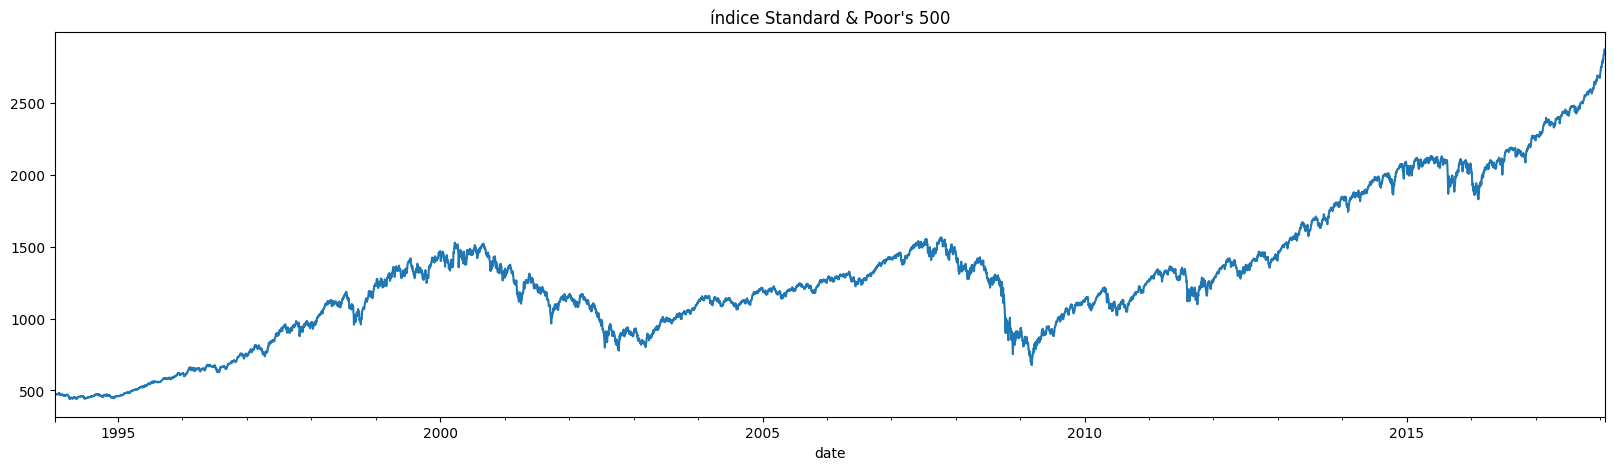

In [11]:
df.spx.plot(figsize=(20,5), title = "índice Standard & Poor's 500")
plt.show()

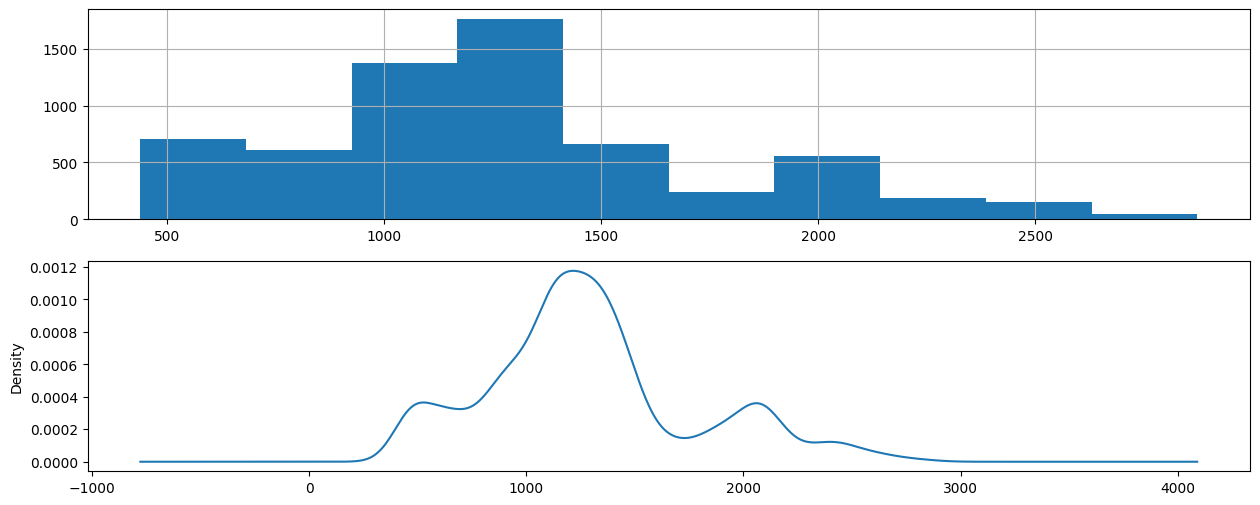

In [12]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["spx"].hist()
plt.subplot(212)
df["spx"].plot(kind='kde')
plt.show()

<h1>Paso 2</h1>
    <h3>Si es necesario utilizar transformacion de Box-Cox para estabilizar la varianza. Aquí se propone una transformación de los datos a fin de mejorar la homocedasticidad. Estas transformaciones se usan para estabilizar la varianza y produce que las desviaciones alrededor del modelo sean mas normalmente distribuidas </ h3>    

In [13]:
#cargar los paquetes necesarios
from scipy.stats import jarque_bera, shapiro, boxcox, probplot

In [14]:
# realizar la transformación de Box-Cox en datos originales
transform_data, best_lambda = boxcox (df.spx)

In [15]:
print(f" El lambda óptima aproximado es =  {best_lambda}")

 El lambda óptima aproximado es =  0.4095477635795529


In [16]:
print(f" El array resultante luego de la transformacion de box-cox es =  {transform_data}")

 El array resultante luego de la transformacion de box-cox es =  [27.89784357 28.03936553 28.00940102 ... 60.93758507 61.24382894
 61.0678994 ]


In [17]:
# Para datos con transformacion de Box Cox
jarque_bera(transform_data)

SignificanceResult(statistic=1.7696944936978196, pvalue=0.412777221484801)

In [18]:
# Para datos originales
jarque_bera(df.spx)

SignificanceResult(statistic=427.0423257470479, pvalue=1.8575358079531404e-93)

# ALTERNATIVA = Usamos algoritmos automatizados
- Usamos Auto arima para encontrar el mejor modelo de series de tiempo.

In [19]:
X = df[['spx' ]]
train, test = X[0:-30], X[-30:]
X.head()

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [20]:
stepwise_model1 = auto_arima(train,max_order= None ,
max_p=2, max_q=2, maxiter= 5000, trace =True ,n_jobs=-1,alpha=0.05)
   # trace=True,suppress_warnings=True)
stepwise_model1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=50262.049, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50291.585, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50272.981, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50271.548, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50293.880, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50260.052, Time=2.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=50266.920, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=50258.389, Time=1.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50260.049, Time=2.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=50268.173, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=50262.617, Time=0.68 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 13.024 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6247
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -25125.195
Date:                Sun, 22 Oct 2023   AIC                          50258.389
Time:                        21:11:51   BIC                          50285.348
Sample:                    01-07-1994   HQIC                         50267.732
                         - 12-18-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1174      0.059      1.993      0.046       0.002       0.233
ar.L1          0.6691      0.055     12.156      0.000       0.561       0.777
ma.L1         -0.7265      0.050    -14.404      0.000      -0.825      -0.628
sigma2       182.6074      1.763    103.564      0.000     179.152     186.063
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              7081.96
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
X_diff=X.copy()
data_diff=X_diff.diff(axis = 0, periods = 1)
data_diff.drop(['1994-01-07'], inplace=True)

In [22]:
train_diff, test_diff = data_diff[0:-30], data_diff[-30:]

In [23]:
stepwise_model2 = auto_arima(train_diff,start_p=1, start_q=1,
max_p=7, max_q=7, seasonal=False,
d=None, trace=True,error_action='ignore',suppress_warnings=True,
stepwise=True)
stepwise_model2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50262.616, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50293.880, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=50275.791, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50274.431, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50264.319, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=50264.322, Time=0.86 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=50270.157, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=50271.302, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=50266.313, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50258.389, Time=1.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50271.548, Time=0.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50272.981, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=50260.049, Time=2.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=50260.051, Time=2.15 sec
 ARIMA(0,0,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6246
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -25125.194
Date:                Sun, 22 Oct 2023   AIC                          50258.389
Time:                        21:14:49   BIC                          50285.348
Sample:                    01-10-1994   HQIC                         50267.732
                         - 12-18-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1174      0.059      1.993      0.046       0.002       0.233
ar.L1          0.6691      0.055     12.156      0.000       0.561       0.777
ma.L1         -0.7265      0.050    -14.404      0.000      -0.825      -0.628
sigma2       182.6074      1.763    103.564      0.000     179.152     186.063
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              7081.95
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Por otro lado, se puede seleccionar el modelo de forma no automatica

3 . Si es necesario, diferenciamos los datos hasta que sean estacionarios. Usar el test de raiz unitaria para comprobar lo dicho.

El test de Dickey Fuller, pone a prueba la estacionariedad de la serie. Es decir, que la raiz sea o no estacionaria. La presencia de estacionariedad es cuando las raices son en modulo mayores que uno.
Regla de decision =

De los modelos AR(p)
- Si el "p-value" es menor a 0.05 --> Rechazo H0
- Si el "p-value" es mayor a 0.05 --> No Rechazo H0

Donde =

<h5>H0 --> no estacionario</h5>
<h5>H1  --> Estacionario</h5>

In [24]:
Augmented_Dickey_Fuller_Test_func(df['spx'],'spx')

Results of Dickey-Fuller Test for column: spx
Test Statistic                    1.119499
p-value                           0.995380
No Lags Used                     10.000000
Number of Observations Used    6266.000000
Critical Value (1%)              -3.431394
Critical Value (5%)              -2.862001
Critical Value (10%)             -2.567016
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [26]:
data_diff.head()

,spx
date,
1994-01-10,5.37
1994-01-11,-1.14
1994-01-12,0.04
1994-01-13,-1.70
1994-01-14,2.44


In [27]:
Augmented_Dickey_Fuller_Test_func(data_diff['spx' ],'spx')

Results of Dickey-Fuller Test for column: spx
Test Statistic                -1.416837e+01
p-value                        2.023543e-26
No Lags Used                   3.400000e+01
Number of Observations Used    6.241000e+03
Critical Value (1%)           -3.431398e+00
Critical Value (5%)           -2.862003e+00
Critical Value (10%)          -2.567017e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


4. Graficamos las funciones de autocorrelacion y autocorrelacion parcial para determinar los posibles modelos.

La funcion de autocorrelacion nos da la pauta, cuando estamos trabajando con un modelo AR(p) si la serie es o no es estacionaria. La grafica que se ve aqui es de un comportamiento de una serie NO estacionaria.
Por otro lado, la funcion de autocorrelacion parcial, nos indica el orden del modelo Autoregresivo. En este ejemplo nos muestra que el primer "lag" es significativo (porque esta por encima de las bandas de significancia)

La funcion de autocorrelacion indica la dependencia directa e indirecta de los lags de la serie trabajada. Por otro lado, la funcion de autocorrelacion parcial nos da la pauta de la relacion directa ( unicamente ).

In [28]:
import matplotlib

matplotlib.rcParams['figure.figsize']=[12.0,8.0]

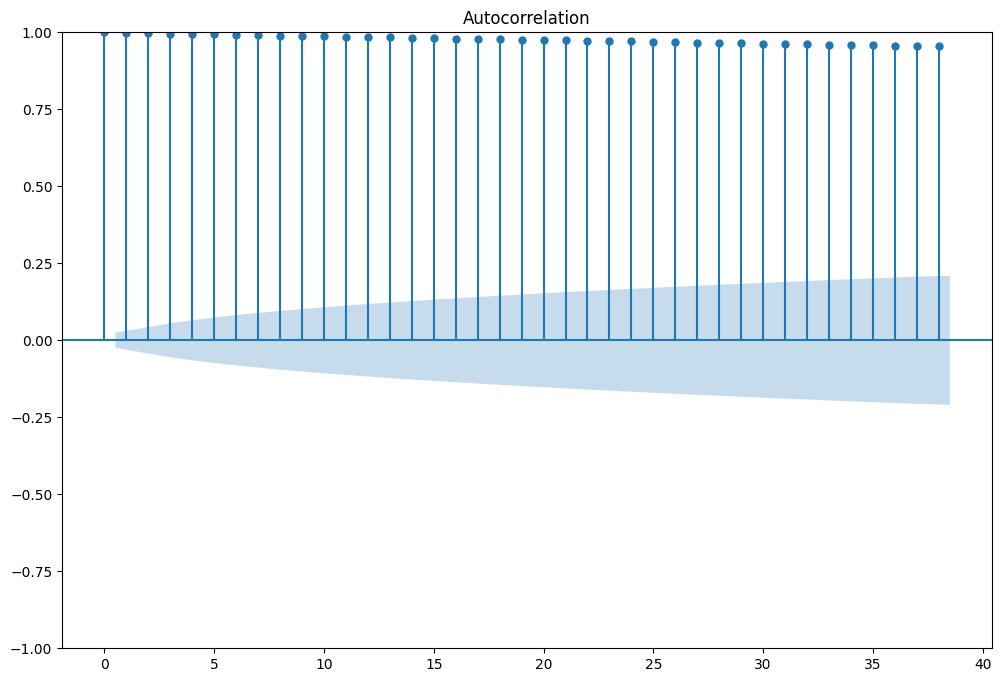

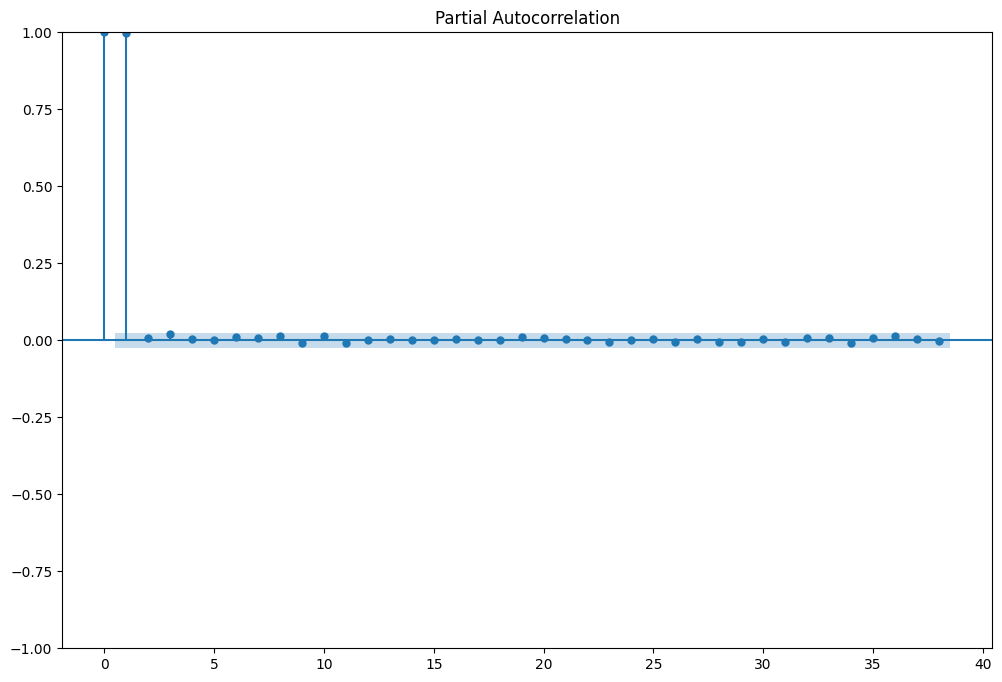

In [29]:
plot_acf(df['spx' ]);
plot_pacf(df['spx' ]);

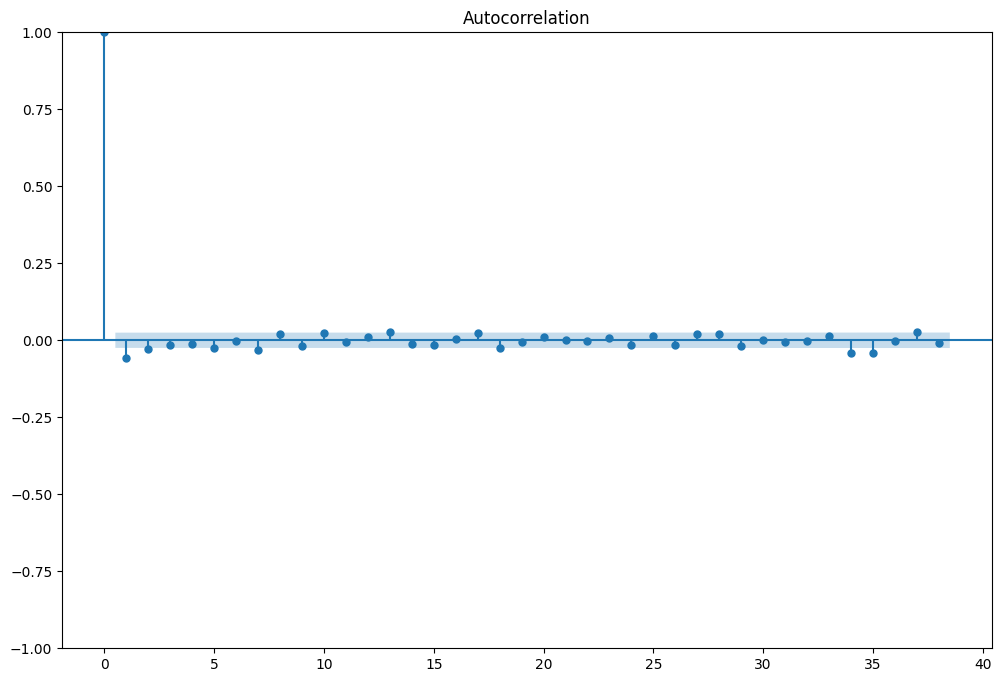

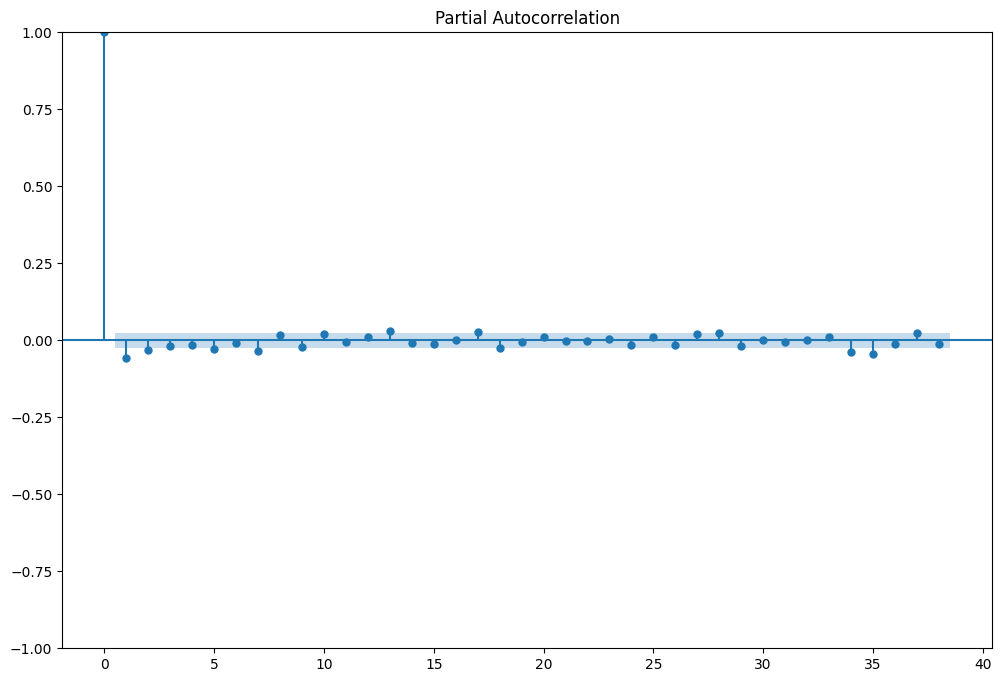

In [30]:
plot_acf(data_diff['spx' ]);
plot_pacf(data_diff['spx' ]);

5. Realizamos una preselección del modelo, y luego verificamos el mejor modelo a través de los criterios de informacion.

In [31]:
from statsmodels.tsa.arima_model import ARMA

import statsmodels.api as sm
model11 = sm.tsa.arima.ARIMA(train_diff.spx, order=(1,0,1))
result11 = model11.fit()

result11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6246
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -25125.194
Date:                Sun, 22 Oct 2023   AIC                          50258.389
Time:                        21:22:47   BIC                          50285.348
Sample:                    01-10-1994   HQIC                         50267.732
                         - 12-18-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3543      0.157      2.253      0.024       0.046       0.663
ar.L1          0.6691      0.055     12.157      0.000       0.561       0.777
ma.L1         -0.7265      0.050    -14.405      0.000      -0.825      -0.628
sigma2       182.6060      1.763    103.565      0.000     179.150     186.062
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              7081.96
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

6. Chequeamos los residuos del modelo elegido.

Los residuos corresponden a la diferencia entre los valores observados y los valores ajustados según el modelo.

Un buen método de pronóstico producirá residuos con las siguientes propiedades:

ESCENCIALES =

1. Los residuos no estén correlacionados. Si hay correlación entre los residuales, esto es que queda información en los residuales que debe usarse para calcular los pronósticos
2. Los residuos tienen media cero. Si tienen media distinta a cero, esto significa que están sesgados.


Propiedades útiles que facilitan el cálculo de los intervalos de predicción
  
FACILITAN EL CALCULO DE LOS INTERVALOS DE PREDICCION.

3. Los residuos tienen varianza constante.

4. Los residuos se distribuyen normalmente.


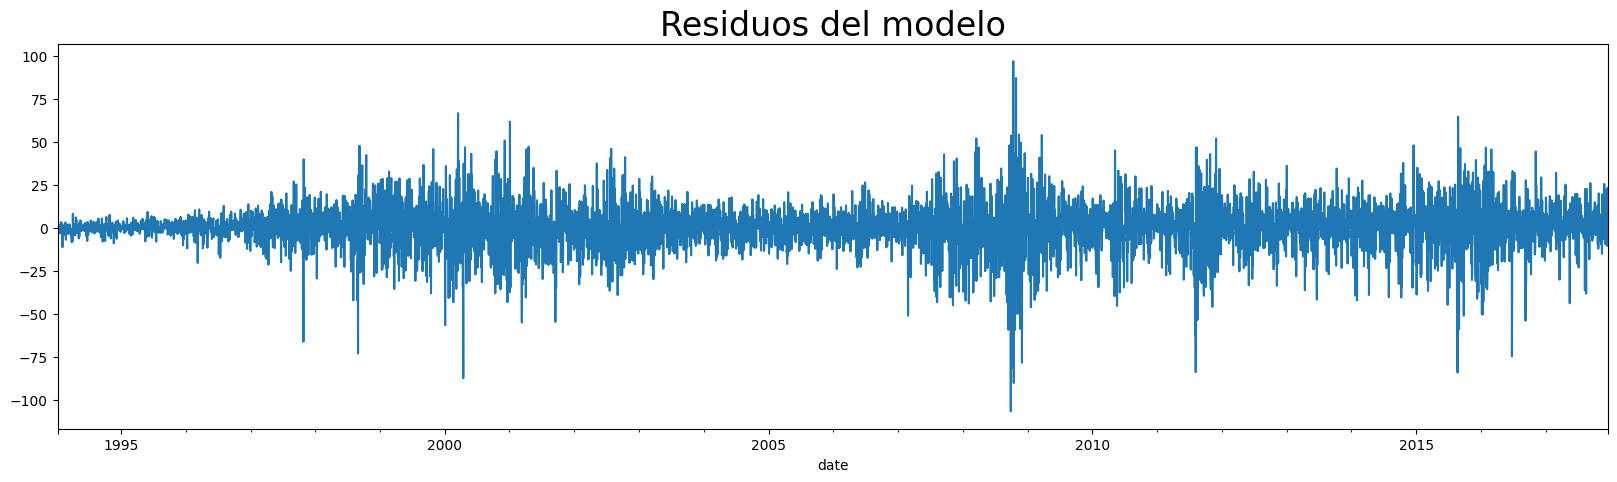

In [32]:
result11.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

Text(0.5, 1.0, 'Histograma de los residuos del modelo')

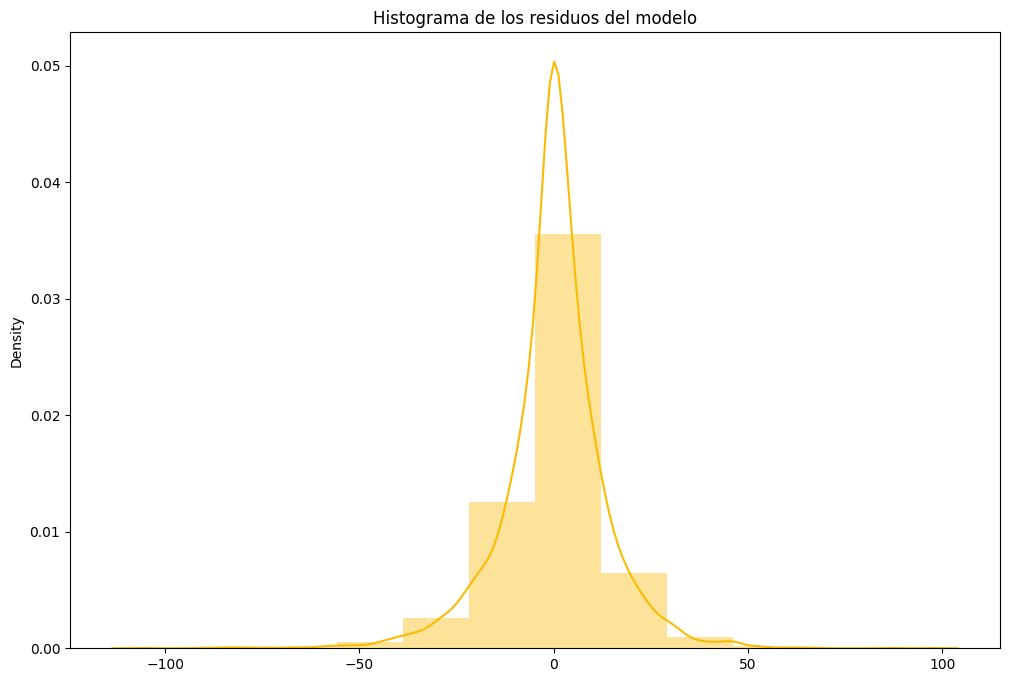

In [33]:
sns.distplot(result11.resid,bins=12,color='#fcba03')
plt.title('Histograma de los residuos del modelo')

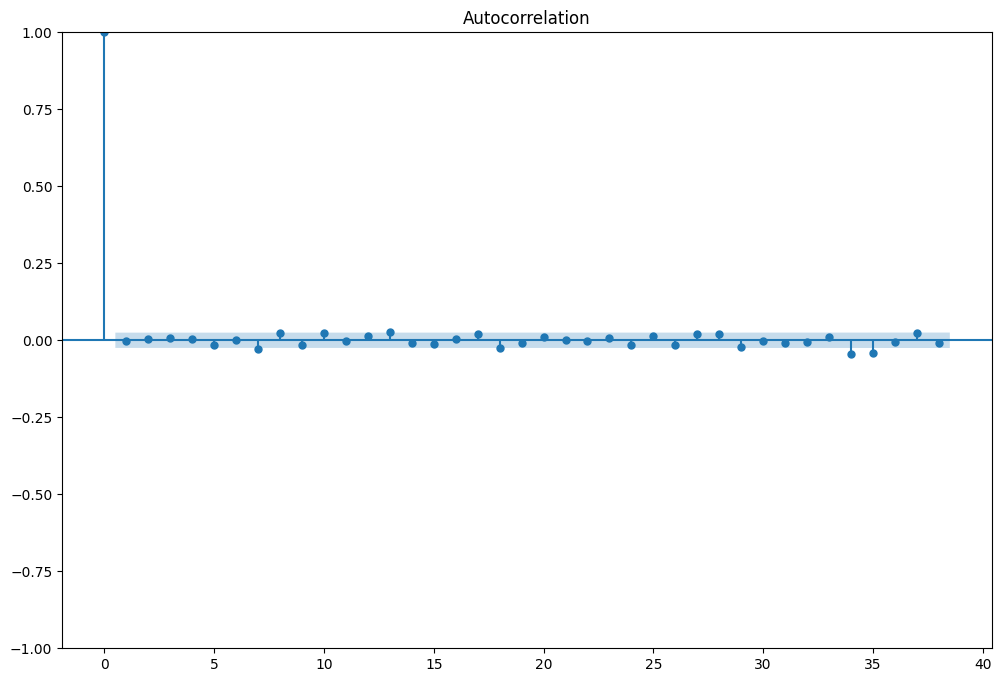

In [34]:
plot_acf(result11.resid);

In [35]:
import scipy.stats
import pylab

Aqui buscamos la normalidad de los residuos del modelo, si bien no es necesario, pero si es importante para una correcta prediccion.

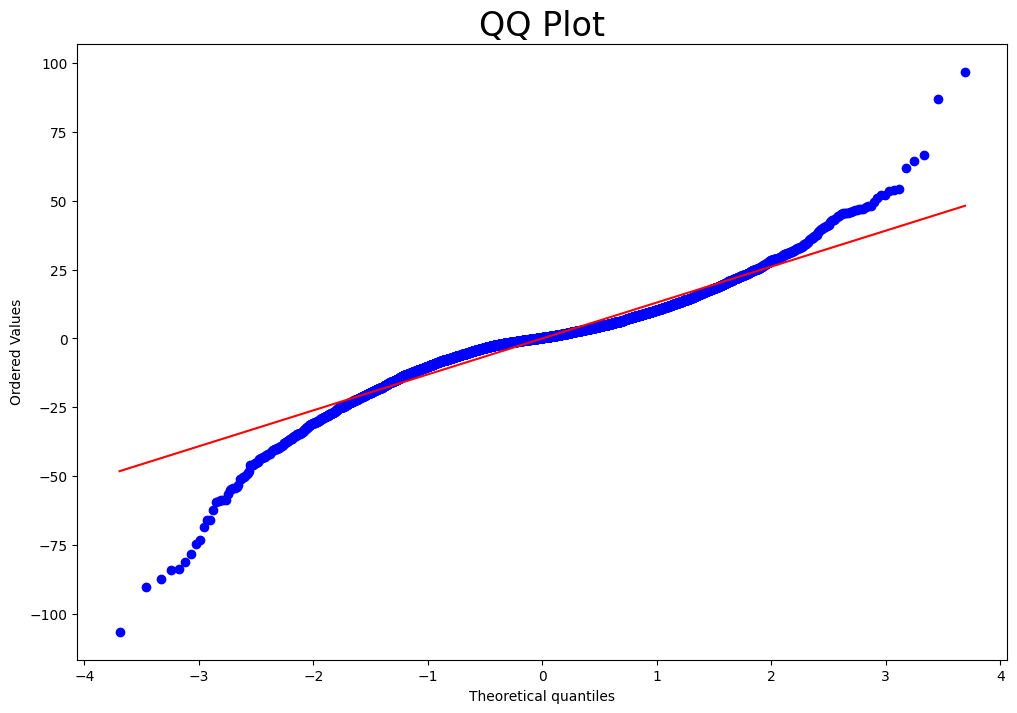

In [36]:
scipy.stats.probplot(result11.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

Aqui trabajamos con el test de L-Jung Box. Trabajamos la incorrelacion o no de los residuos del modelo. Si hay algun valor que rechazo, entonces algun componente no estoy especificando bien en mi modelo y tiene correlacion. Entonces, tendria que incorporarlo a la especificacion. Este test es fundamental cuando analizo los residuos del modelo que tienen que comportarse como un ruido blanco.

In [37]:
import statsmodels.api as sm

In [38]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(result11.resid, lags=30)

In [39]:
Incorr_residuos_modelo

,lb_stat,lb_pvalue
1,0.097930,0.754328
2,0.302650,0.859568
3,0.552977,0.907108
4,0.615662,0.961307
5,2.077799,0.838279
6,2.102343,0.910049
7,7.262658,0.402054
8,10.741527,0.216779
9,12.197523,0.202402
10,15.806627,0.105303


Text(0, 0.5, 'P-valores ')

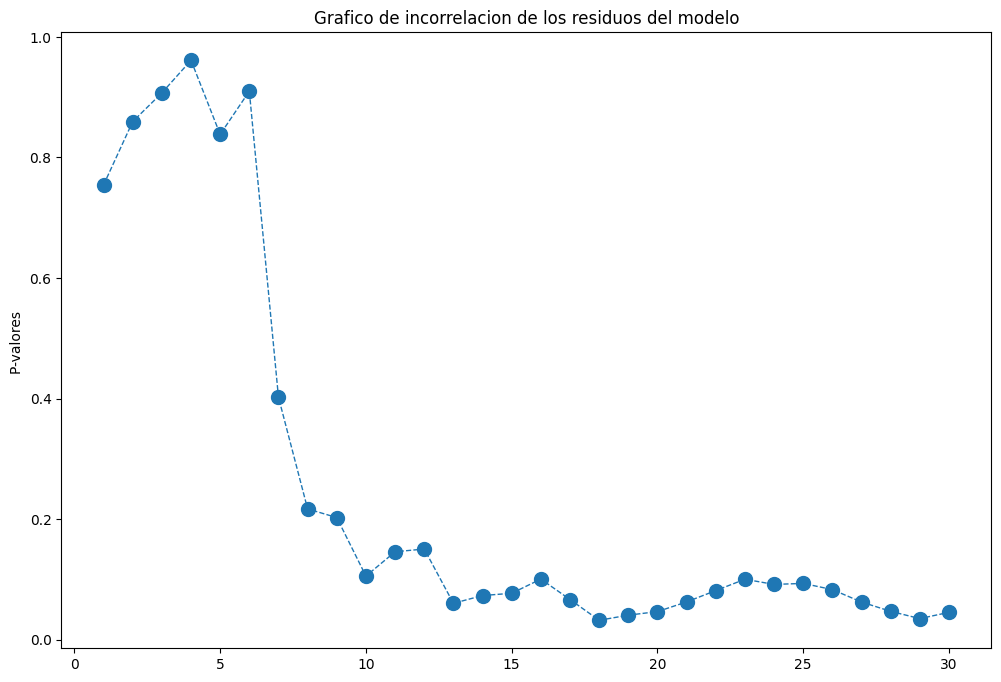

In [40]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

Si los residuos del modelo se comportan como ruido blanco, hacemos la proyeccion. En este ejemplo no se comportan pero continuamos con el proceso.

In [41]:
forecast,conf_int = stepwise_model2.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
#df_conf["new_index"] = range(6246, 6276)
#df_conf = df_conf.set_index("new_index")

In [42]:
import numpy as np
import pandas as pd

my_array = np.array(conf_int)

df = pd.DataFrame(my_array, columns = ['Limite_Inferior','Limite_Superior'])

print(df)
print(type(df))

    Limite_Inferior  Limite_Superior
0        -27.849206        25.121691
1        -27.324221        25.734000
2        -26.963272        26.133994
3        -26.717442        26.397295
4        -26.551026        26.571530
5        -26.438814        26.687242
6        -26.363348        26.764275
7        -26.312682        26.815642
8        -26.278704        26.849934
9        -26.255936        26.872843
10       -26.240686        26.888155
11       -26.230476        26.898394
12       -26.223641        26.905241
13       -26.219067        26.909821
14       -26.216006        26.912885
15       -26.213958        26.914934
16       -26.212587        26.916305
17       -26.211670        26.917223
18       -26.211056        26.917836
19       -26.210645        26.918247
20       -26.210371        26.918522
21       -26.210187        26.918706
22       -26.210064        26.918829
23       -26.209982        26.918911
24       -26.209926        26.918966
25       -26.209890        26.919003
2

In [43]:
import datetime
import pandas as pd
start = datetime.datetime.strptime("2017-12-19", "%Y-%m-%d")
date_generated = pd.date_range(start, periods=len(df), freq='b')
print(date_generated.strftime("%Y-%m-%d"))

Index(['2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-25',
       '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2018-01-01',
       '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08',
       '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-15',
       '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-22',
       '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29'],
      dtype='object')


In [44]:
df['Periodos'] = np.array(date_generated)

In [45]:
df.set_index("Periodos", inplace=True)
df.head()

,Limite_Inferior,Limite_Superior
Periodos,,
2017-12-19,-27.849206,25.121691
2017-12-20,-27.324221,25.734000
2017-12-21,-26.963272,26.133994
2017-12-22,-26.717442,26.397295
2017-12-25,-26.551026,26.571530


In [46]:
df['forecast']=forecast.close_pred

In [47]:
df.head()

,Limite_Inferior,Limite_Superior,forecast
Periodos,,,
2017-12-19,-27.849206,25.121691,-1.363757
2017-12-20,-27.324221,25.734000,-0.795110
2017-12-21,-26.963272,26.133994,-0.414639
2017-12-22,-26.717442,26.397295,-0.160073
2017-12-25,-26.551026,26.571530,0.010252


In [48]:
df['test_diff']=test_diff

In [50]:
df.head()

,Limite_Inferior,Limite_Superior,forecast,test_diff
Periodos,,,,
2017-12-19,-27.849206,25.121691,-1.363757,-8.684622
2017-12-20,-27.324221,25.734000,-0.795110,-2.225544
2017-12-21,-26.963272,26.133994,-0.414639,5.321091
2017-12-22,-26.717442,26.397295,-0.160073,-1.231902
2017-12-25,-26.551026,26.571530,0.010252,0.000000


<Axes: xlabel='Periodos'>

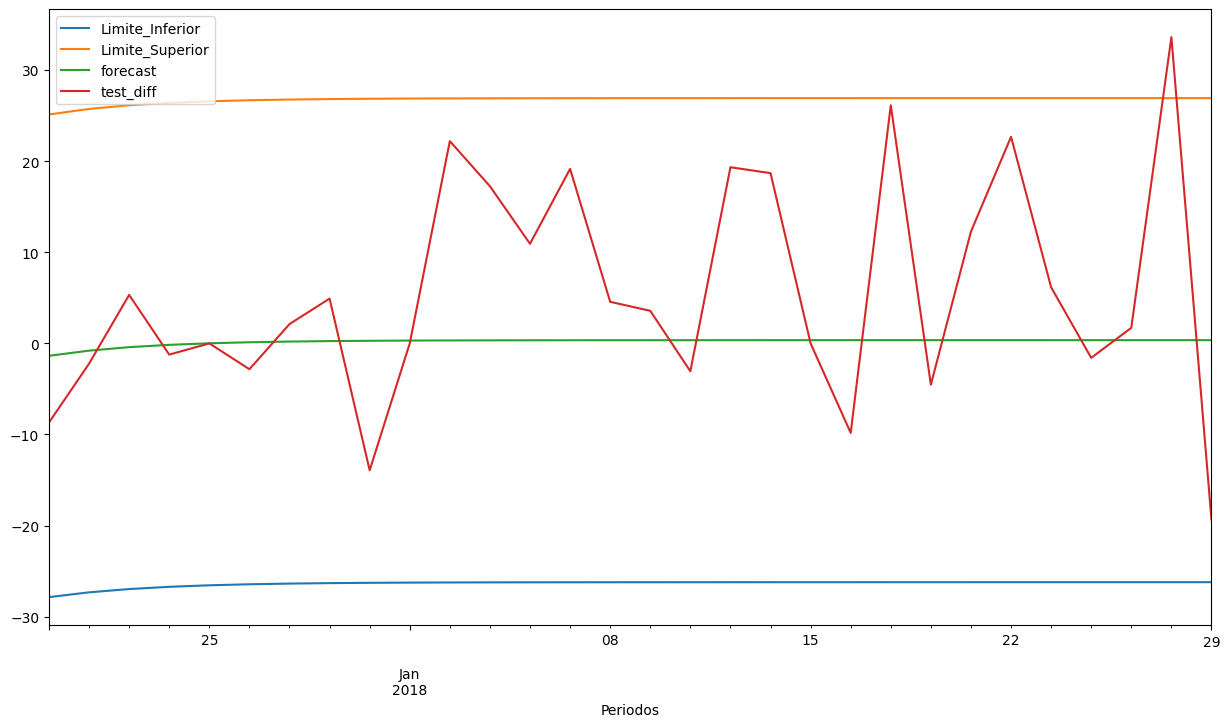

In [51]:
df.plot.line(y=['Limite_Inferior', 'Limite_Superior', 'forecast', 'test_diff'], figsize=(15,8))

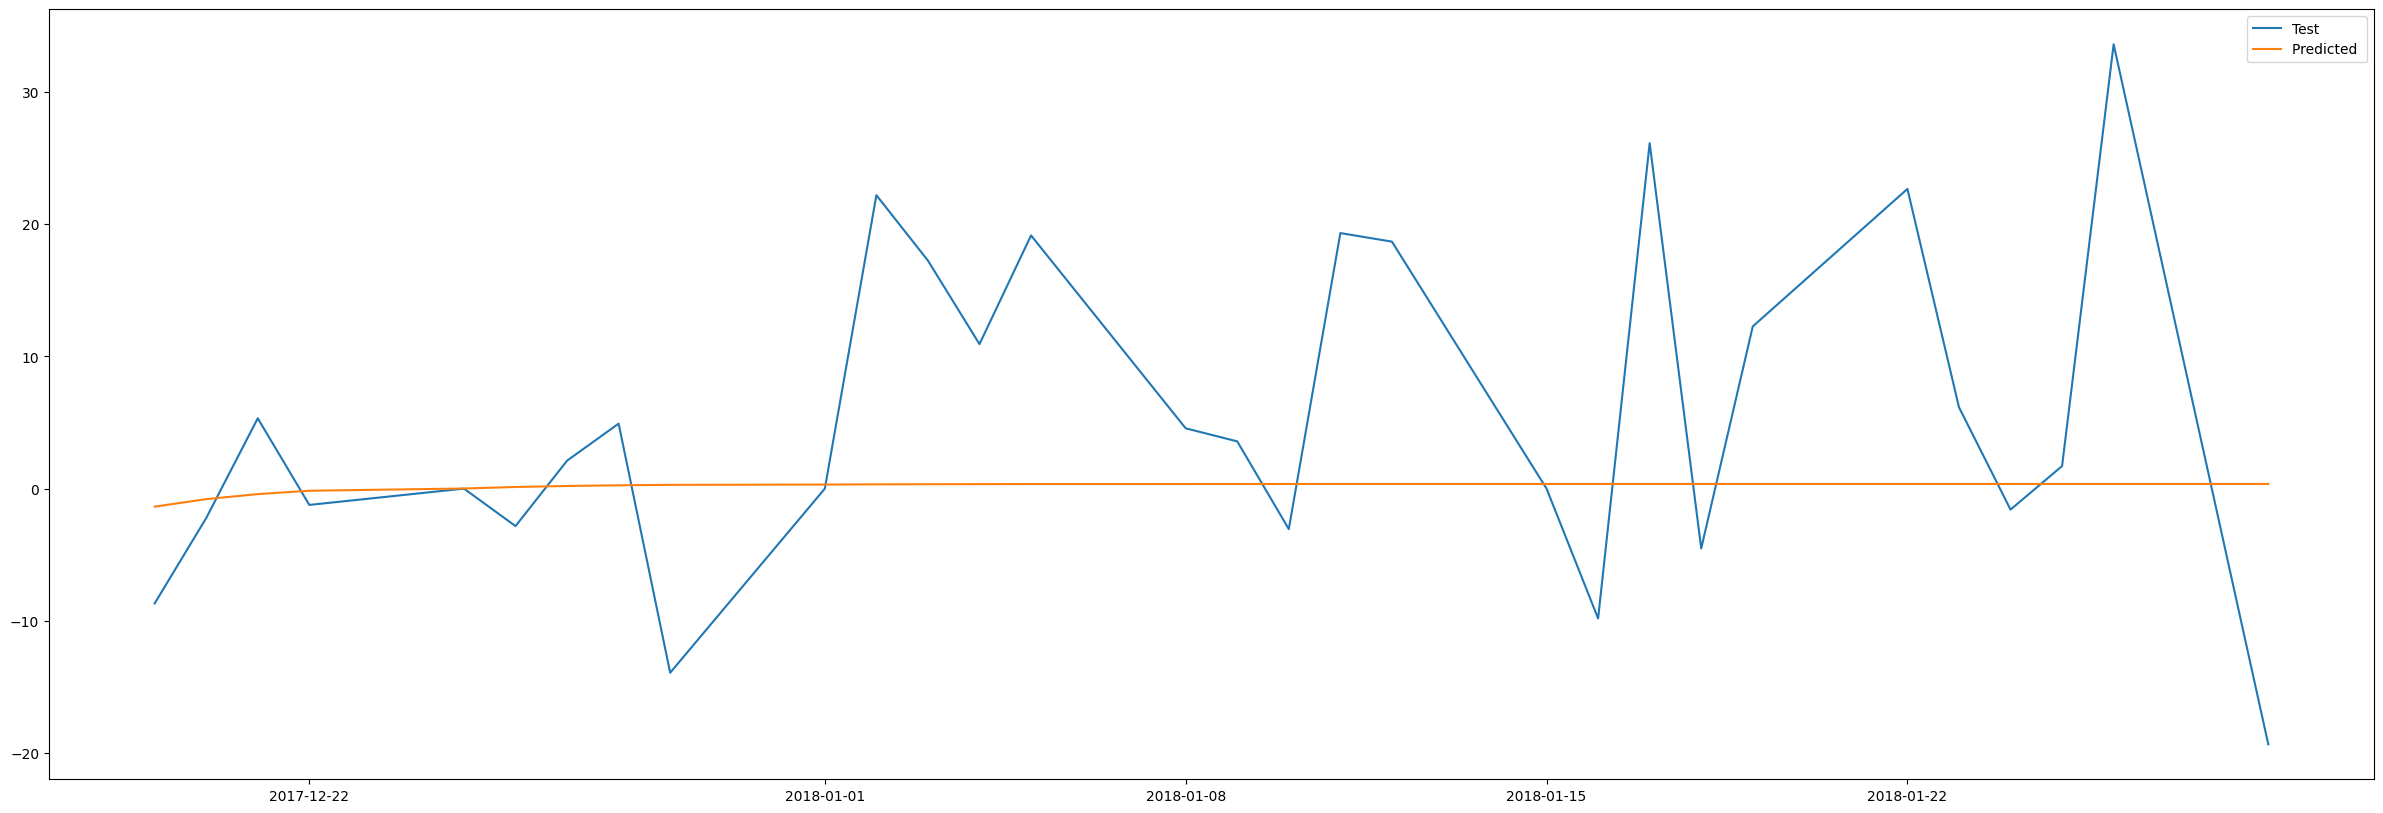

In [52]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [30,10]
# plt.plot(train_diff, label='Train ')
plt.plot(test_diff, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.legend(loc='best')
plt.show()

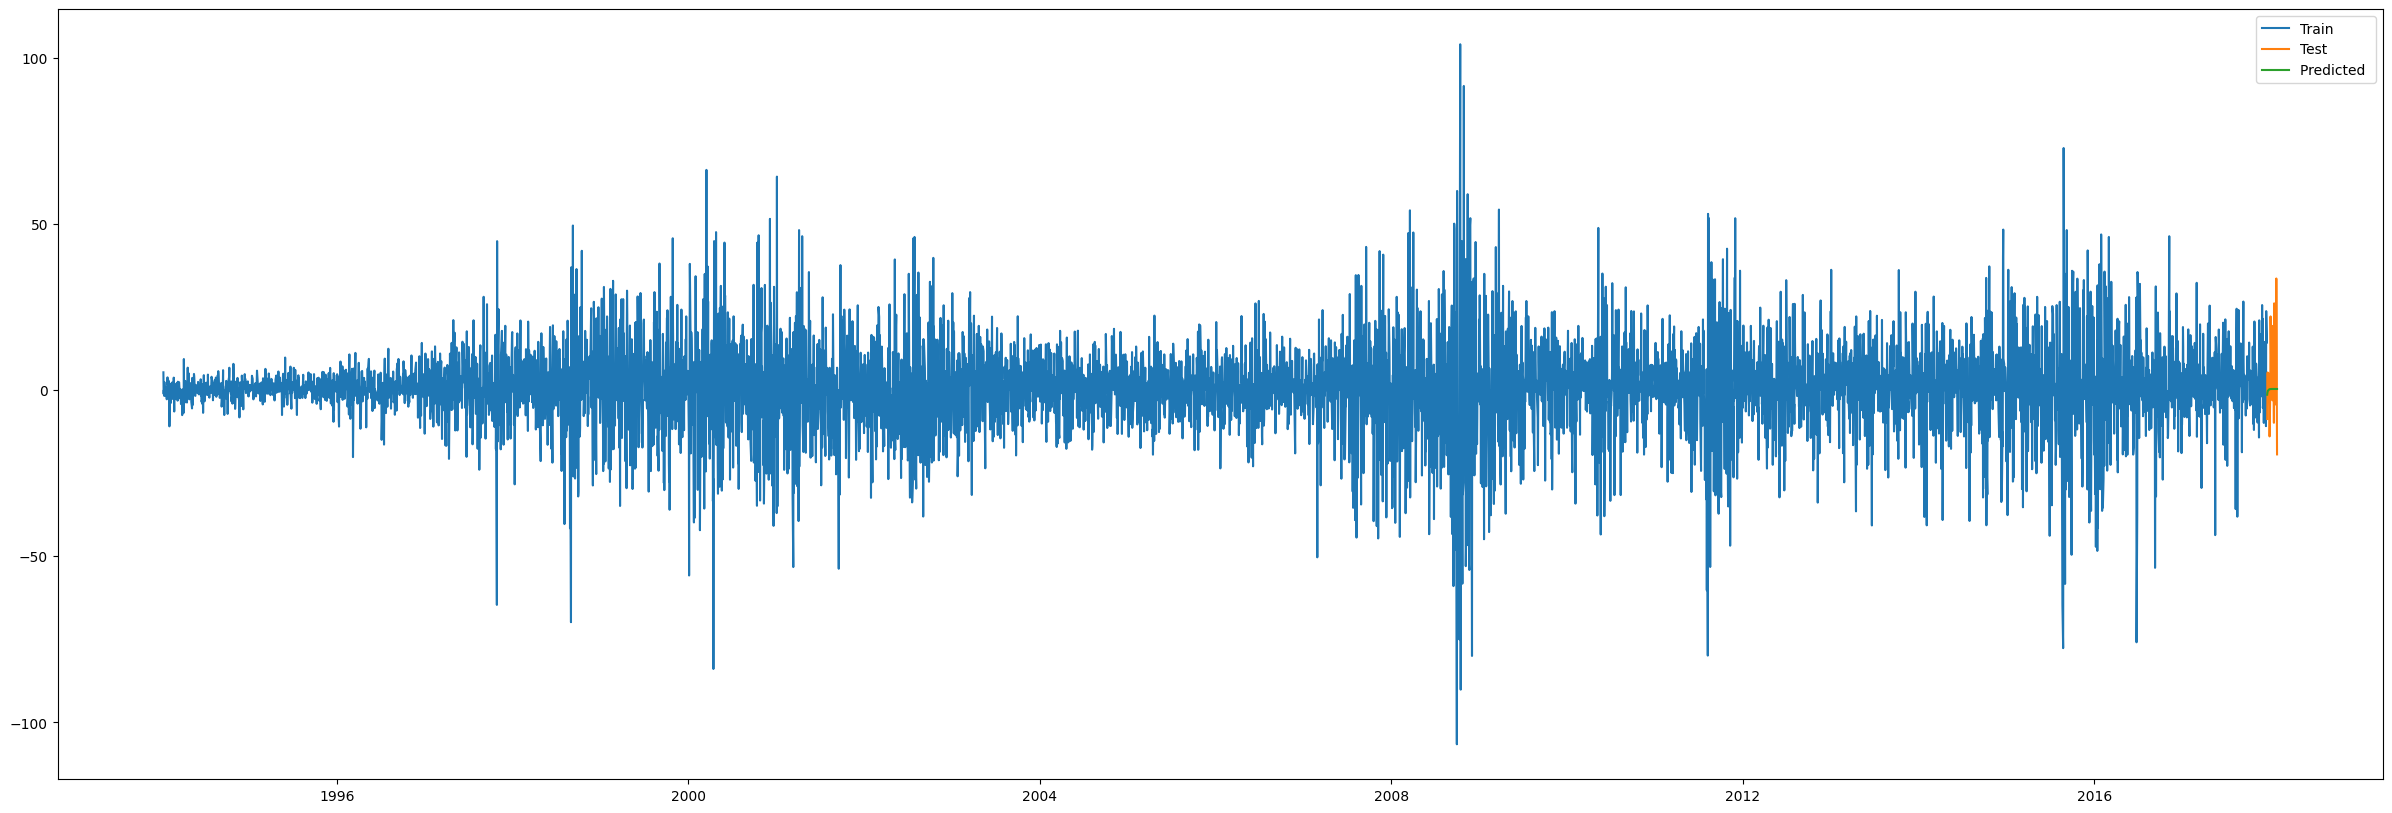

In [53]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [30,10]
plt.plot(train_diff, label='Train ')
plt.plot(test_diff, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.legend(loc='best')
plt.show()

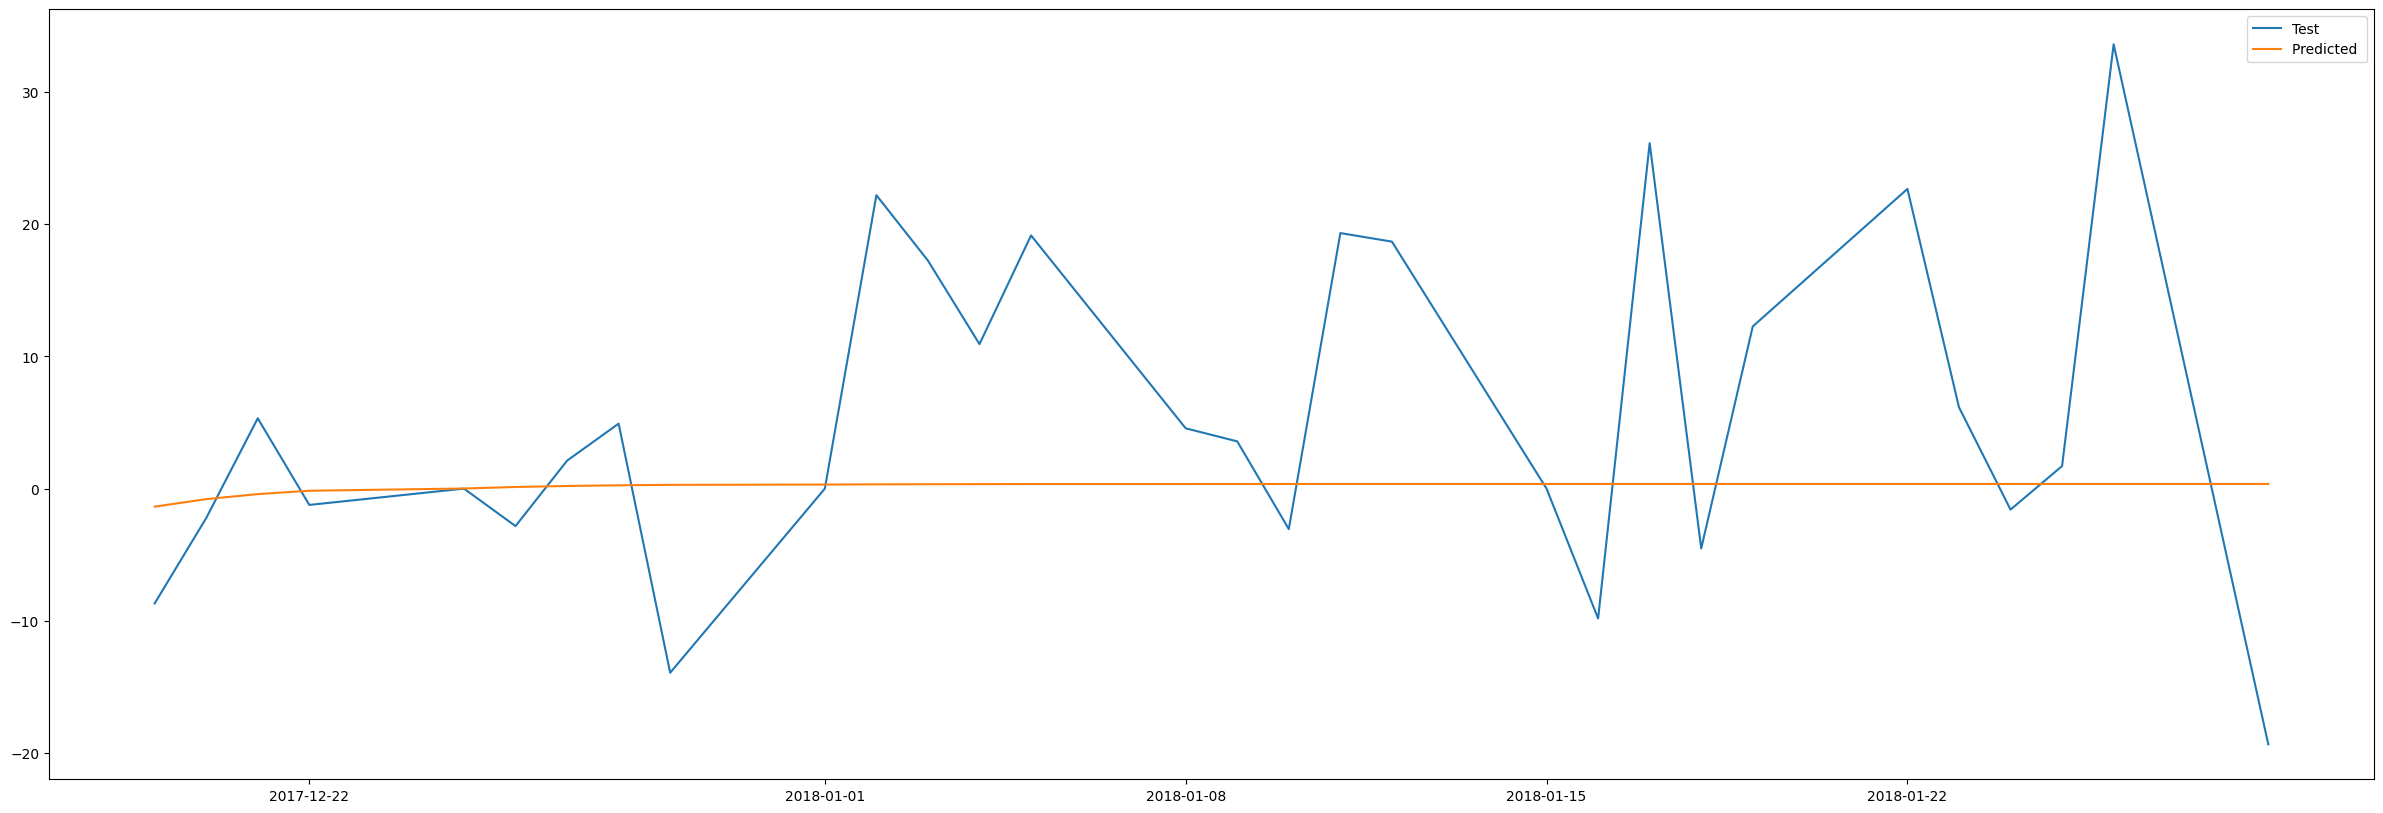

In [55]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [30,10]
# plt.plot(train_diff, label='Train ')
plt.plot(test_diff, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.legend(loc='best')
plt.show()

In [58]:
timeseries_evaluation_metrics_func(test_diff, forecast)

Evaluation metric results:-
MSE is : 175.28149583092602
MAE is : 9.782135711374663
RMSE is : 13.239391822547063
MAPE is : inf
R2 is : -0.16701798876691476



Aqui confirmamos , mediante los graficos, la mala prediccion del modelo. Es importante destacar que la serie original se trata de un indice bursatil que tiene un comportamiento similar al teorico de "Random Walk" y el mismo no es bueno para hacer predicciones.

😀 Fin del codigo. Gracias